In [1]:
# Calculate galaxy clustering data vectors using CCL, with parameters matching the DESC SRD v1
# Use the actual covariance matrix from the DESC SRD v1

In [2]:
import matplotlib.pyplot as plt
import classy
import pyccl as ccl
import numpy as np
from scipy.ndimage import gaussian_filter
import sacc

In [3]:
h=0.6727
cosmo = ccl.Cosmology(
    Omega_c=0.2664315,
    Omega_b=0.0491685,
    Omega_k=0.0,
    w0=-1.0,
    wa=0.0,
    sigma8 = 0.831,
    n_s=0.9645,
    h=h,
)

In [4]:
year = 'Y1'
if year=='Y1' or year==1 or year=='y1':
    nbin_z = 5
    z0 = 0.26
    alpha = 0.94
    sig_z = 0.03
    Ngal = 18 # Normalisation, galaxies/arcmin^2
    linear_bias = np.array([1.562362, 1.732963, 1.913252, 2.100644, 2.293210])
    bias_mag = np.array([-0.898,-0.659,-0.403,-0.0704,0.416])
else:
    print('only Y1 implemented currently')

In [5]:
bin_edges = np.linspace(0.2, 1.2, nbin_z+1)
bin_low_zs = bin_edges[:-1]
bin_high_zs = bin_edges[1:]
zmids = (bin_low_zs+bin_high_zs)/2

nbin_ell = 20 
lmin = 20
lmax = 15000
ell_edges = np.geomspace(lmin, lmax, nbin_ell+1)
ell_centers = [lmin**(1-(i+0.5)/nbin_ell)*lmax**((i+0.5)/nbin_ell) for i in range(nbin_ell)]

chis = ccl.comoving_radial_distance(cosmo, 1/(1+zmids)) # Mpc
kmax = 0.3*h
lmax = kmax*chis-0.5
print(chis, lmax)

z= np.linspace(0., 3., 1001)
#redshift distribution normalized to galaxy number density -- I don't think the normalization matters
pz = (z / z0)**2. * np.exp(-(z / z0)**alpha) # Redshift distribution, p(z)
norm = 1.0#Ngal/np.trapz(pz, z)
nz = norm * pz # Number density distribution

[1238.63709255 1954.66113835 2588.85128733 3150.07658539 3647.8892709 ] [249.46935165 393.97016433 521.9560783  635.2169557  735.68053376]


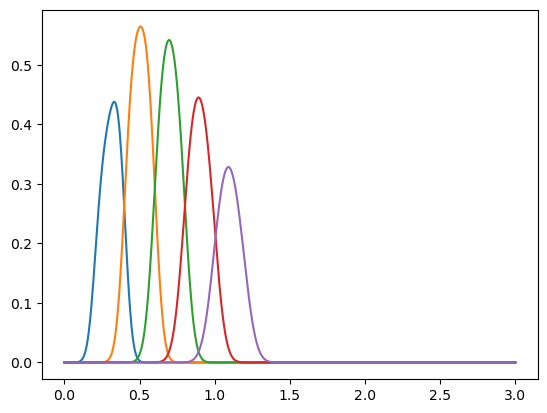

In [6]:
tracers = []
b_mag = np.ones(len(z))
for i, zmin in enumerate(bin_low_zs):
    zmax = bin_high_zs[i]
    zmid = zmids[i]
    nz_bin = np.zeros_like(z)
    nz_bin[(z>zmin) & (z<zmax)] = nz[(z>zmin) & (z<zmax)]
    dz = z[1]-z[0]
    nz_bin = gaussian_filter(nz_bin, sig_z*(1+zmid)/dz)
    
    # galaxy clustering CCL tracer for computing mock datavector
    galaxy_tracer_bin = ccl.NumberCountsTracer(cosmo, has_rsd=False, dndz=(z,nz_bin), n_samples=len(z), bias=(z,linear_bias[i]*np.ones(len(z))), mag_bias=(z,bias_mag[i]*np.ones(len(z))))
    tracers.append(galaxy_tracer_bin)
    plt.plot(z, nz_bin, label=str(i))

plt.show()

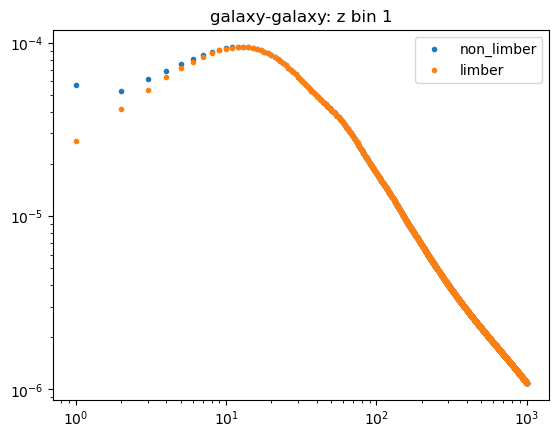

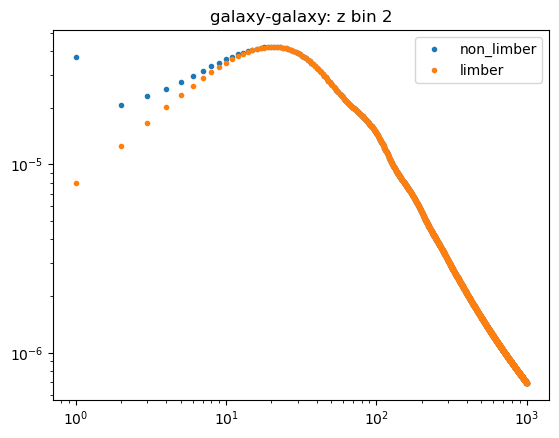

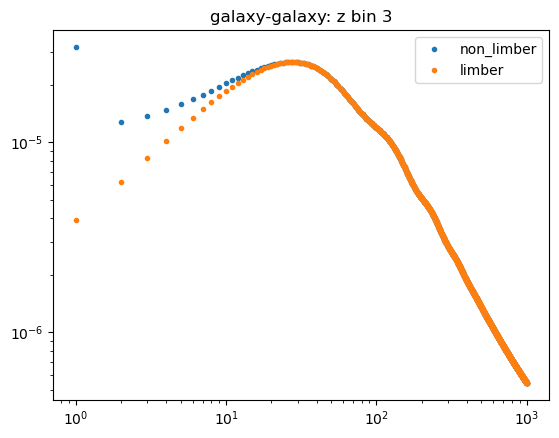

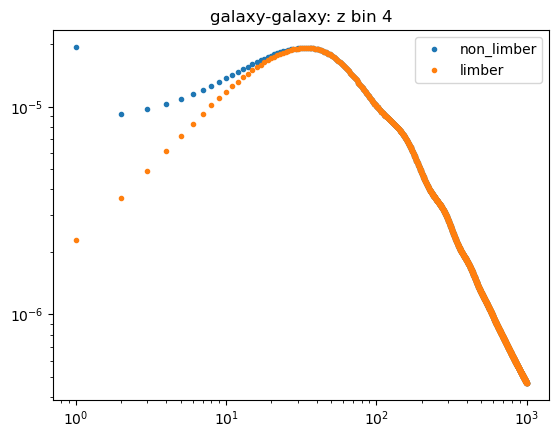

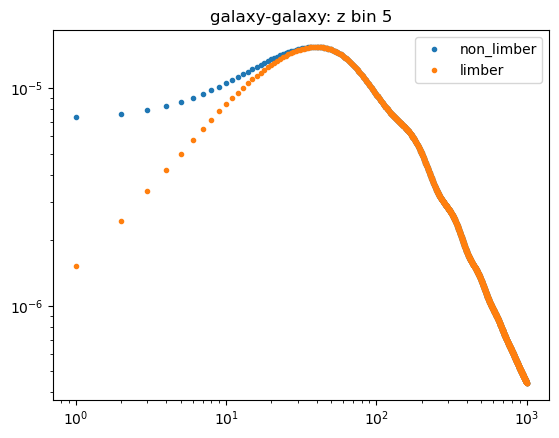

In [7]:
ell_unbinned = np.arange(1, 1001)
for i in range(nbin_z):
    limit = 500
    cl_zbin_i = ccl.angular_cl(cosmo, tracers[i], tracers[i], ell_unbinned, l_limber="auto", limber_max_error=0.001)
    cl_zbin_i_limber = ccl.angular_cl(cosmo, tracers[i], tracers[i], ell_unbinned, l_limber=-1)
    
    plt.loglog(ell_unbinned, cl_zbin_i, '.', label='non_limber')
    plt.loglog(ell_unbinned, cl_zbin_i_limber, '.', label='limber')
    plt.legend()
    plt.title('galaxy-galaxy: z bin '+str(i+1))
    plt.show()


In [8]:
#shear n(z) calculations
nbin_z = 5
z0 = 0.191
alpha = 0.870
sig_z = 0.05
Ngal = 11.2 # Normalisation, galaxies/arcmin^2

bin_edges = np.linspace(0.2, 2.0, nbin_z+1)
bin_low_zs = bin_edges[:-1]
bin_high_zs = bin_edges[1:]
zmids = (bin_low_zs+bin_high_zs)/2

nbin_ell = 20 
lmin = 20
lmax = 15000
ell_edges = np.geomspace(lmin, lmax, nbin_ell+1)
ell_centers = [lmin**(1-(i+0.5)/nbin_ell)*lmax**((i+0.5)/nbin_ell) for i in range(nbin_ell)]

chis = ccl.comoving_radial_distance(cosmo, 1/(1+zmids)) # Mpc
kmax = 0.3*h
lmax = kmax*chis-0.5
print(chis, lmax)

z= np.linspace(0., 3., 1001)
#redshift distribution normalized to galaxy number density -- I don't think the normalization matters
pz = (z / z0)**2. * np.exp(-(z / z0)**alpha) # Redshift distribution, p(z)
norm = 1.0#Ngal/np.trapz(pz, z)
nz = norm * pz # Number density distribution

[1535.34454912 2706.62699804 3647.8892709  4412.17971096 5042.99491134] [ 309.34788346  545.72439447  735.68053376  889.92198747 1017.22680306]


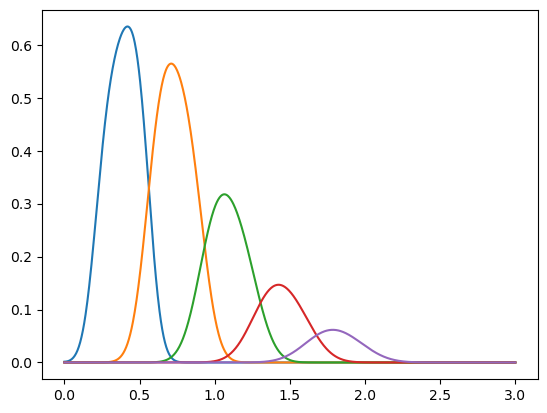

In [9]:
#Shear tracers

b_mag = np.zeros(len(z))
for i, zmin in enumerate(bin_low_zs):
    zmax = bin_high_zs[i]
    zmid = zmids[i]
    nz_bin = np.zeros_like(z)
    nz_bin[(z>zmin) & (z<zmax)] = nz[(z>zmin) & (z<zmax)]
    dz = z[1]-z[0]
    nz_bin = gaussian_filter(nz_bin, sig_z*(1+zmid)/dz)
    
    # galaxy shear CCL tracer for computing mock datavector
    galaxy_tracer_bin = ccl.WeakLensingTracer(cosmo, has_shear=True, dndz=(z,nz_bin), n_samples=len(z), ia_bias=(z,0.5*np.ones(len(z))), use_A_ia=True)
    tracers.append(galaxy_tracer_bin)
    plt.plot(z, nz_bin, label=str(i))
plt.show()

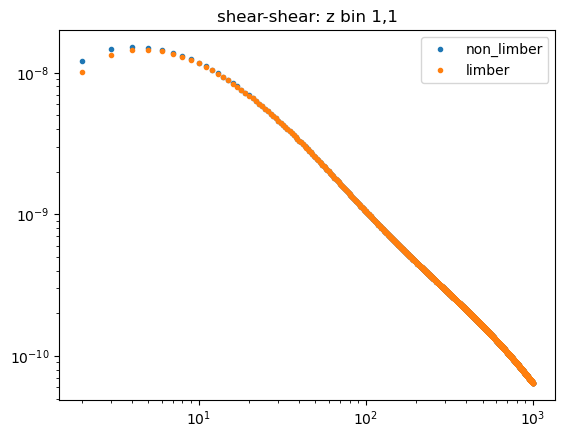

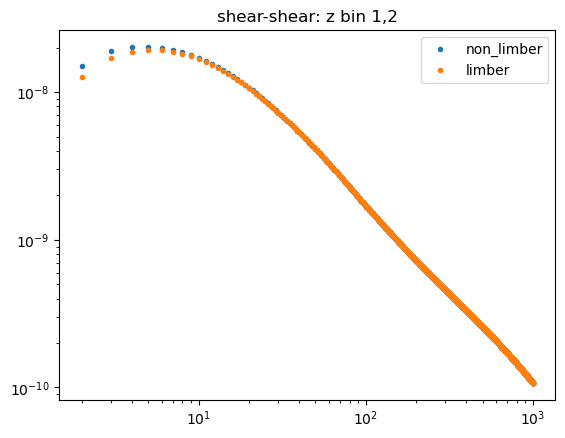

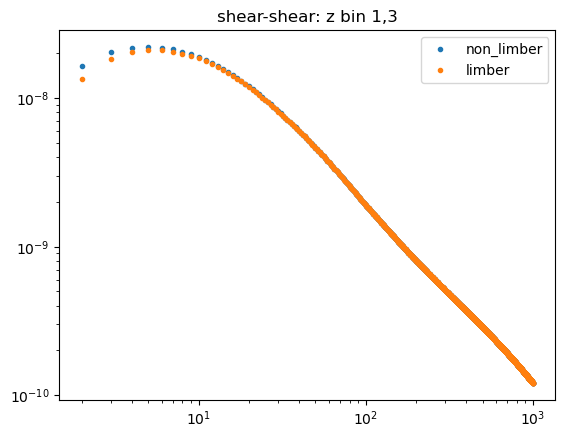

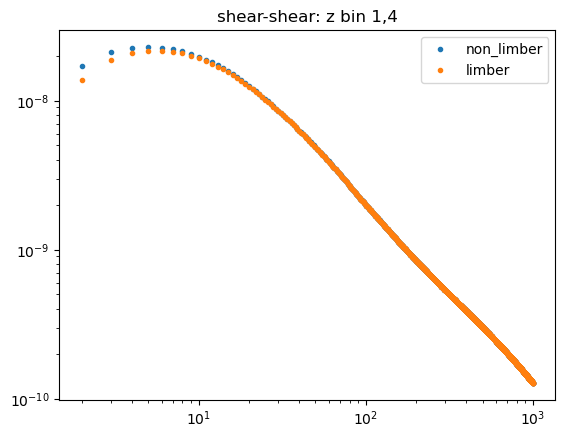

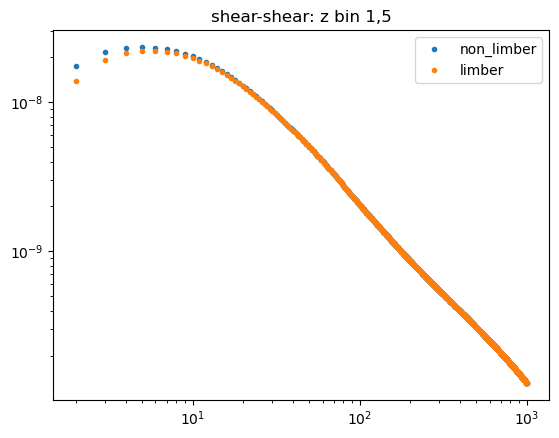

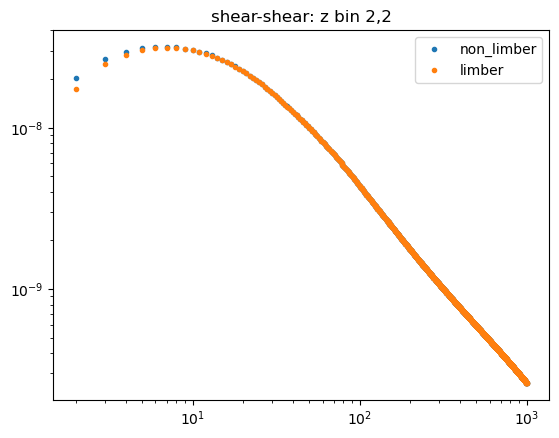

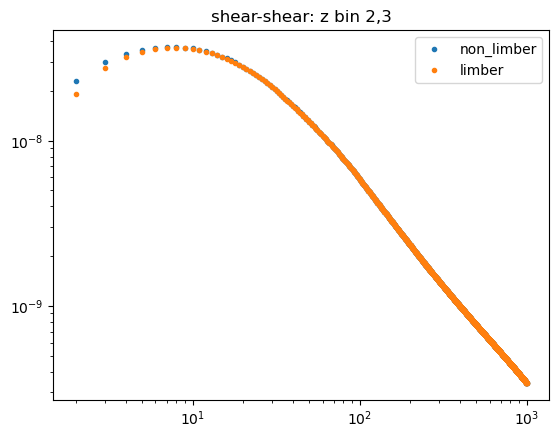

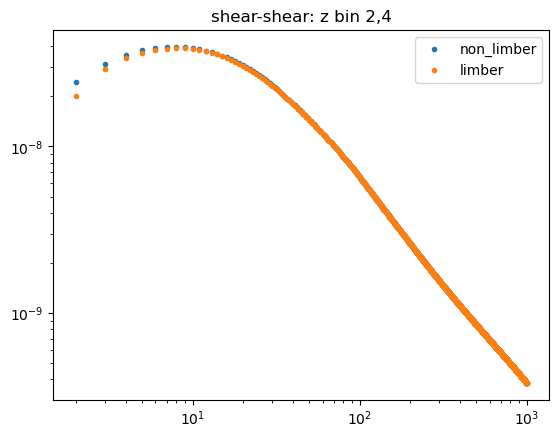

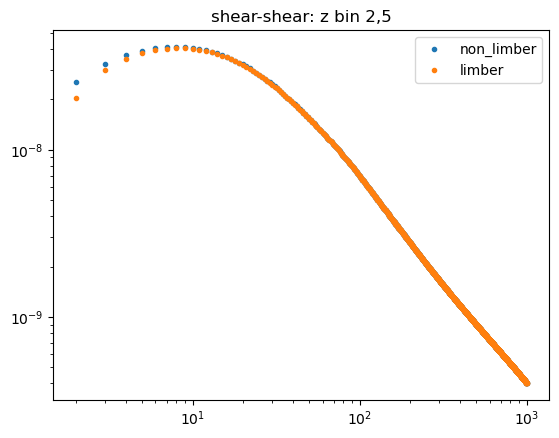

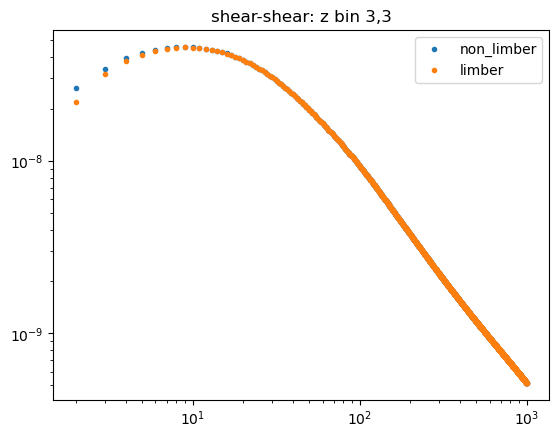

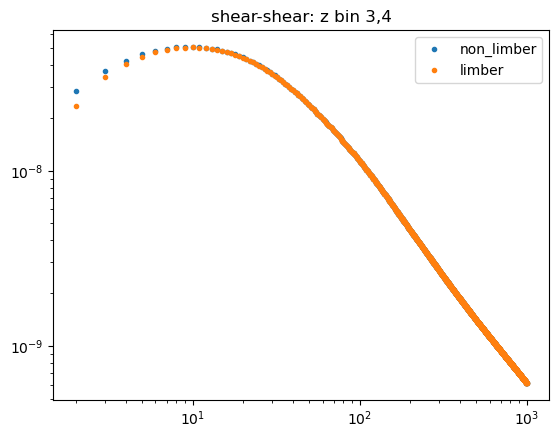

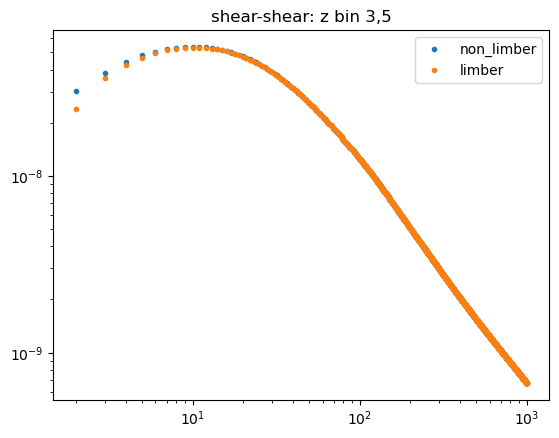

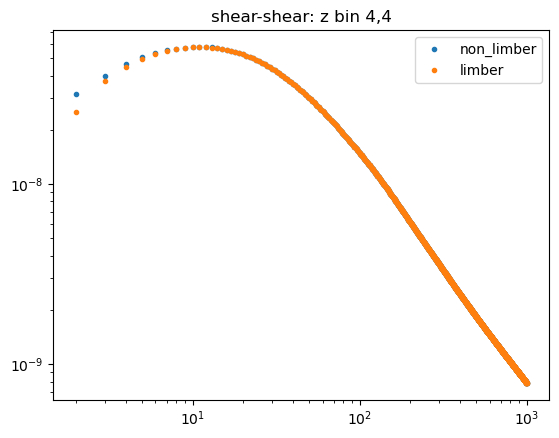

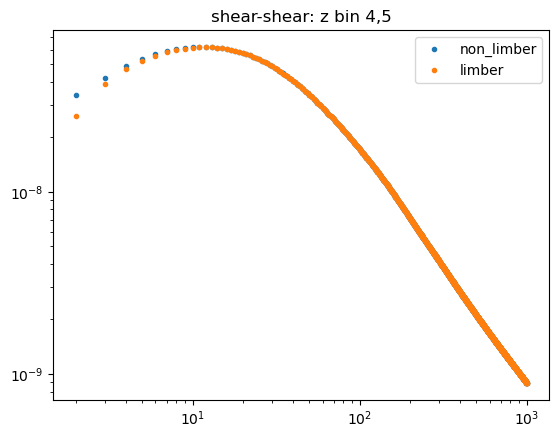

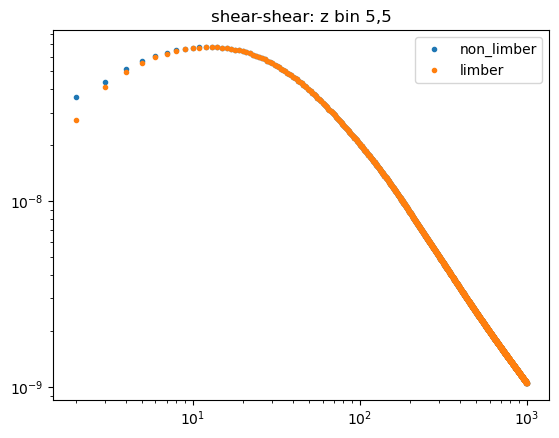

In [10]:
ell_unbinned = np.arange(2, 1001)
for i in range(nbin_z):
    for j in range(i,nbin_z):
        limit = 'auto'
        cl_zbin_i = ccl.angular_cl(cosmo, tracers[nbin_z+i], tracers[nbin_z+j], ell_unbinned, l_limber=limit, limber_max_error=0.0001)
        cl_zbin_i_limber = ccl.angular_cl(cosmo, tracers[nbin_z+i], tracers[nbin_z+j], ell_unbinned, l_limber=-1)

        plt.plot(ell_unbinned, cl_zbin_i, '.', label='non_limber')
        plt.plot(ell_unbinned, cl_zbin_i_limber, '.', label='limber')
        plt.yscale('log')
        plt.xscale('log')
        plt.legend()
        plt.title('shear-shear: z bin '+str(i+1)+','+str(j+1))
        plt.show()

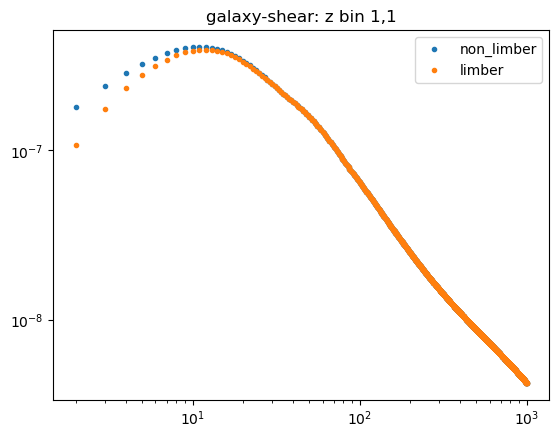

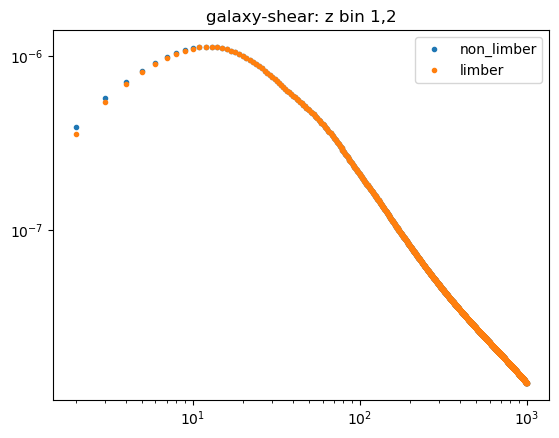

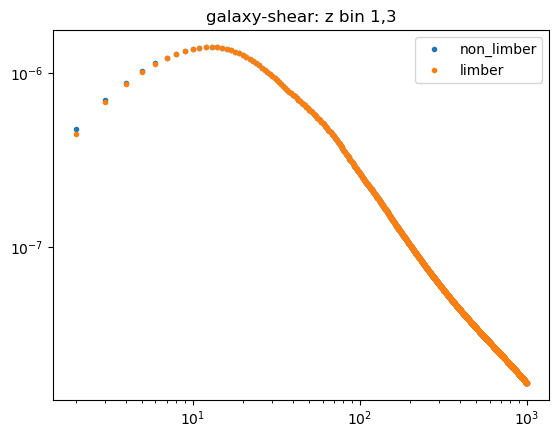

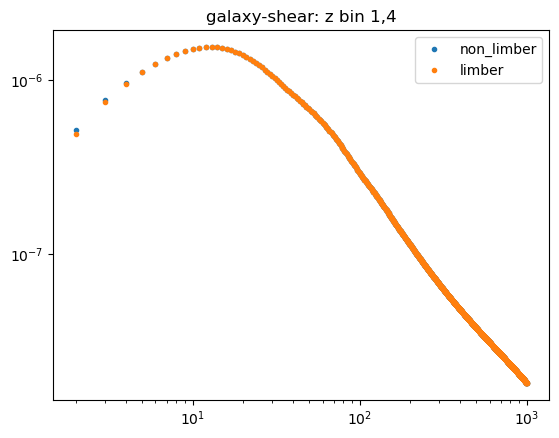

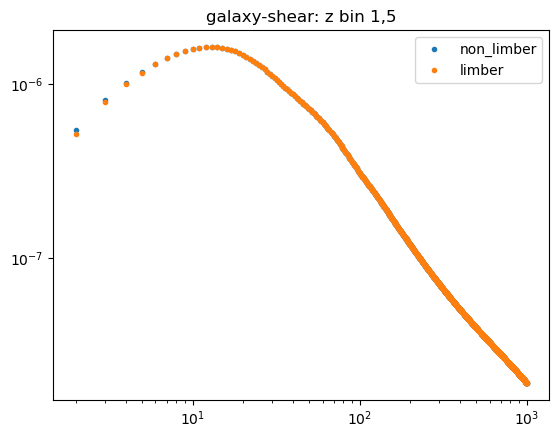

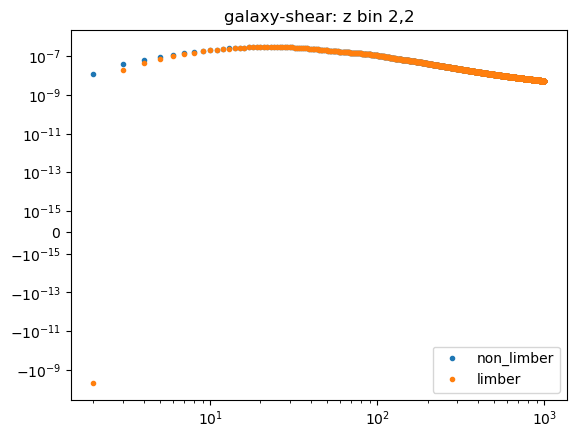

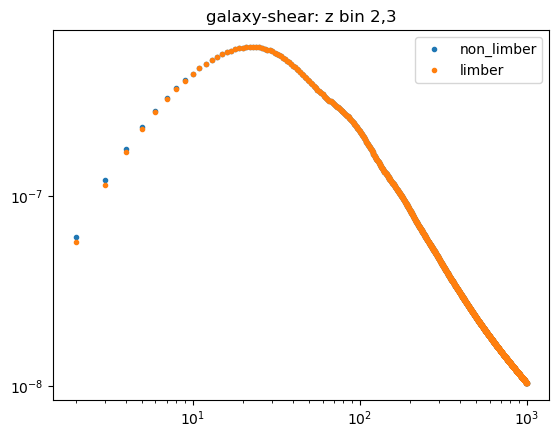

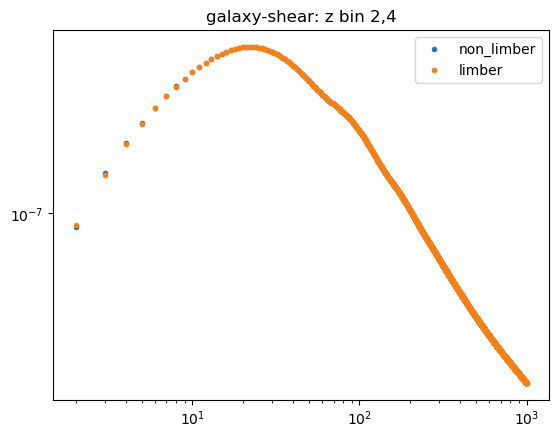

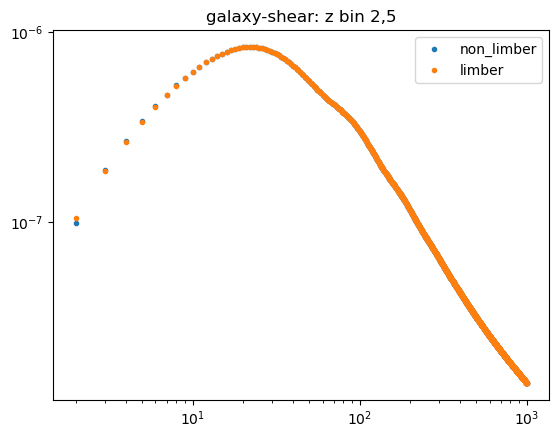

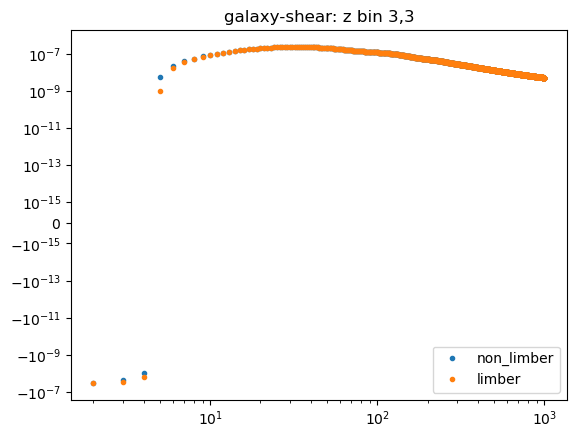

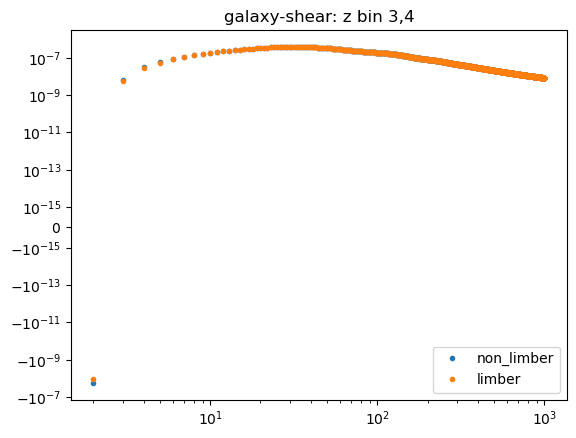

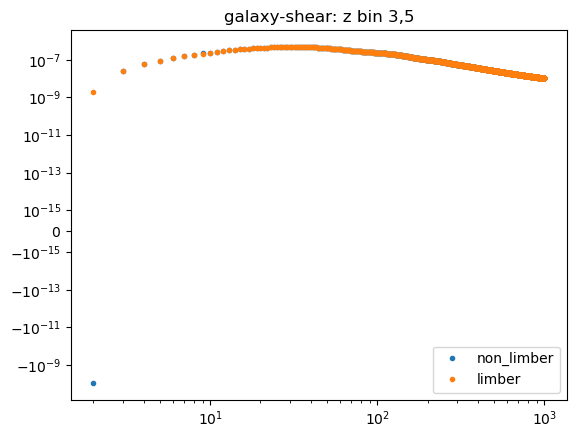

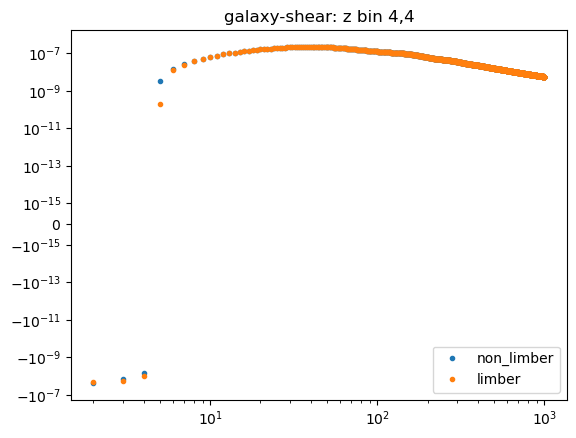

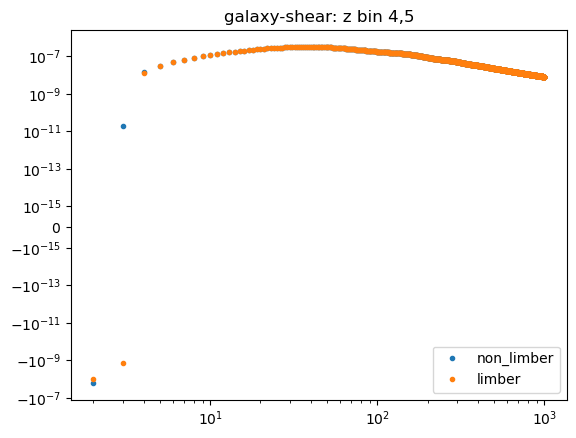

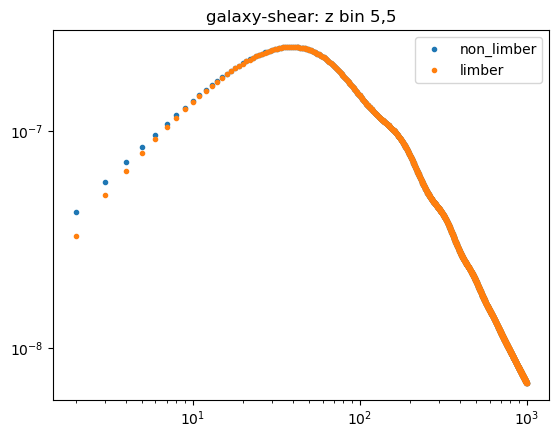

In [11]:
ell_unbinned = np.arange(2, 1001)
for i in range(nbin_z):
    for j in range(i,nbin_z):
        limit = 'auto'
        cl_zbin_i = ccl.angular_cl(cosmo, tracers[i], tracers[nbin_z+j], ell_unbinned, l_limber=limit, limber_max_error=0.001)
        cl_zbin_i_limber = ccl.angular_cl(cosmo, tracers[i], tracers[nbin_z+j], ell_unbinned, l_limber=-1)
        plt.plot(ell_unbinned, cl_zbin_i, '.', label='non_limber')
        plt.plot(ell_unbinned, cl_zbin_i_limber, '.', label='limber')
        plt.yscale('symlog',linthresh=1.e-15)
        plt.xscale('log')
        plt.legend()
        plt.title('galaxy-shear: z bin '+str(i+1)+','+str(j+1))
        plt.show()